### Firstly, we are going to texture a 3D mesh using mayavi lib

In [1]:
from osgeo import gdal
from tvtk.api import tvtk
from mayavi import mlab
import Image

In [2]:
im1 = Image.open("texture6.jpg")

In [3]:
im2 = im1.rotate(90)
im2.save("tmp/texture6.jpg")

In [4]:
bmp1 = tvtk.JPEGReader(file_name="tmp/texture6.jpg")

In [5]:
my_texture=tvtk.Texture()
my_texture.interpolate=0

In [6]:
# my_texture.set_input(0,bmp1.get_output())
#tvtk.configure_input(my_texture, bmp1)
my_texture=tvtk.Texture(input_connection=bmp1.output_port, interpolate=0)

In [7]:
surf=mlab.pipeline.surface(mlab.pipeline.open("PLY/ASR.ply"))

In [8]:
surf.actor.enable_texture = True
surf.actor.tcoord_generator_mode = 'plane'
surf.actor.actor.texture = my_texture
#mlab.show()
mlab.show()

### we are going to smaple images' pixels from images

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline

In [10]:
img=mpimg.imread('tissue.jpg')

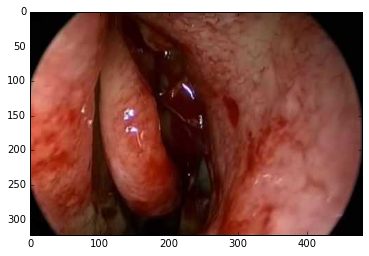

In [11]:
plt.imshow(img)
plt.show()

In [12]:
img.shape

(323L, 480L, 3L)

In [13]:
import random
import cv2
sample_array=[]
r=50
center=[img.shape[0]/2,50]
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if (i-center[0])**2+(j-center[1])**2<=100**2:
            sample_array.append(list(img[i,j,:]))
            
#array=np.array(sample_array)
length=len(sample_array)

constructed_image=[]
for i in range(img.shape[0]):
    temp_array=[]
    for j in range(img.shape[1]):
        randnum=random.randint(0,length-1)
        temp_array.append(sample_array[randnum])
    constructed_image.append(temp_array)
constructed_image=np.array(constructed_image)

In [14]:
blur = cv2.GaussianBlur(constructed_image,(7,7),0)
dst = cv2.fastNlMeansDenoisingColored(blur,None,10,10,7,21)

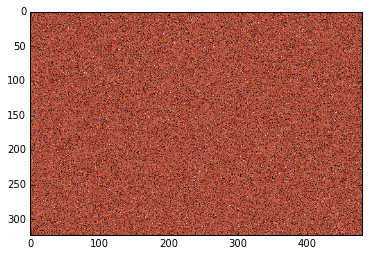

In [15]:
plt.imshow(constructed_image)
plt.show()

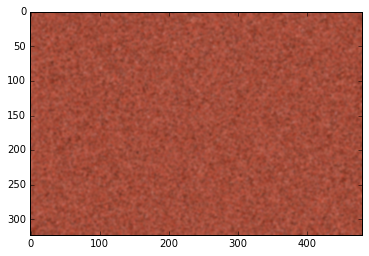

In [16]:
plt.imshow(blur)
plt.show()

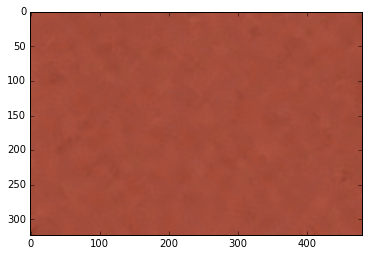

In [17]:
plt.imshow(dst)
plt.show()

In [18]:
import scipy.misc
scipy.misc.imsave('sampled_texture.jpg', blur)

### Now,we are going to use sampled image to texture 3D-mesh 

In [19]:
from osgeo import gdal
from tvtk.api import tvtk
from mayavi import mlab
import Image

im1 = Image.open("sampled_texture.jpg")
im2 = im1.rotate(90)
im2.save("tmp/sampled_texture.jpg")
bmp1 = tvtk.JPEGReader(file_name="tmp/sampled_texture.jpg")

my_texture=tvtk.Texture()
my_texture.interpolate=0
my_texture=tvtk.Texture(input_connection=bmp1.output_port, interpolate=0)

In [20]:
surf=mlab.pipeline.surface(mlab.pipeline.open("PLY/target.ply"))
surf.actor.enable_texture = True
surf.actor.tcoord_generator_mode = 'plane'
surf.actor.actor.texture = my_texture

In [21]:
image_file_names=[]
for i in range(100):
    image_file_names.append("saved_images/screenshot"+str(i)+".png")

camera_poses=[]
camera_focs=[]
for i in range(100):
    cam,foc = mlab.move()
    camera_poses.append(cam)
    camera_focs.append(foc)
    mlab.savefig(image_file_names[i])
    x=random.uniform(-1,1)
    y=random.uniform(-1,1)
    z=random.uniform(-1,1)
    mlab.move(x,y,z)
    degree1=random.uniform(-0.5,0.5)
    degree2=random.uniform(-0.5,0.5)
    mlab.pitch(degree1)
    mlab.yaw(degree2)

In [26]:
improt 
camera_poses=np.array(camera_poses)
dic_poses={}
for i in range(100):
    dic_poses["screen shot "+str(i)+" pose"]=list(camera_poses[i])
dic_poses
with open('data.json', 'w') as fp:
    json.dump(data, fp)

{'screen shot 0 pose': [-0.75388526916503906,
  0.792999267578125,
  161.9308679262507],
 'screen shot 1 pose': [-1.7476995726976345,
  -0.09440765809496543,
  162.85852740081486],
 'screen shot 10 pose': [-2.8641501320707348,
  -2.3940226764253603,
  160.02832472783371],
 'screen shot 11 pose': [-2.2037694172593376,
  -1.4635733805811535,
  160.91640728660124],
 'screen shot 12 pose': [-3.2198278287386146,
  -1.4211469307136384,
  160.24226182166518],
 'screen shot 13 pose': [-4.0556778544748644,
  -1.9057137568660194,
  159.60612337929396],
 'screen shot 14 pose': [-4.0483982070854561,
  -1.4771588098192638,
  159.8192566709576],
 'screen shot 15 pose': [-3.0772527906443639,
  -2.2123977306976039,
  159.14203514006101],
 'screen shot 16 pose': [-2.8145590148408788,
  -1.6827061548884013,
  158.48600075720745],
 'screen shot 17 pose': [-3.6672634023866157,
  -0.96856291942365969,
  158.64555361680615],
 'screen shot 18 pose': [-3.0134462434222984,
  0.009591898130358989,
  158.1995303

In [27]:
#mlab.show()
mlab.show()

### Then, we need to calculate camera's translation and rotation

In [55]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img1 = cv2.imread('3D-mesh-image-screen-shot/shot1.png',0)  #queryimage # left image
img2 = cv2.imread('3D-mesh-image-screen-shot/shot3.png',0) #trainimage # right image
sift = cv2.SIFT()
#sift = cv2.xfeatures2d.SIFT_create() 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
#matches = flann.knnMatch(None,None,k=2)
good = []
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [56]:
pts1 = np.float32(pts1)
pts2 = np.float32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

In [57]:
F

array([[  3.00509119e-05,   3.69686461e-05,  -1.17710095e-02],
       [ -2.66883598e-05,  -1.25196832e-05,   7.92030192e-03],
       [ -1.15878857e-03,  -5.80374852e-03,   1.00000000e+00]])

In [58]:
# E,mask2=cv2.findEssentialMat(pts1,pts2,1.0)
# E, mask = cv2.findEssentialMat(pts1, pts2, 1.0)
# points, R, t, mask = cv2.recoverPose(E, points1, points2)
#mask